# Testing Recovery of DNA sequence post sequencing errors with different methods

In [19]:
%load_ext autoreload
%autoreload 2

## Loading the data
Currently simulating a single strand repeated about a 1000 times and repeating that 100 times. I will test the different methods on their ability to recover that strand. In post, I will repeat this for multiple strands in order to test how good clustering is as seperating strand repeats into individual clusters

In [5]:
from synthesis import NaiveSynthesisModel
from sequencing import NaiveSequencingModel
from tqdm.notebook import tqdm

strand_models = []
simulation_repeats = 100
repeats_per_strand = 1000
strand_length = 200
sequencing_model = NaiveSequencingModel(strand_length=strand_length)

for simulation_repeat in tqdm(range(simulation_repeats)):
    strand_model =  NaiveSynthesisModel(
            coupling_rate=9.9,
            strand_length=strand_length,
            repeats=repeats_per_strand,
            capping=True
        )
    strand_model.simulate_synthesis()
    strand_model.sequenced_strands = sequencing_model.simulate_full_sequencing(strand_model.synthesized_strands)
    strand_models.append(strand_model)


### Best Matching strand

In [6]:
def get_best_strand_match_recovery(reference, sequenced_strands):

    best_strand_match_recovery = 0
    
    for sequenced_strand in sequenced_strands:    
        recovery_percentage = sum([i==j for i, j in zip(sequenced_strand, reference)])/len(reference)

        if recovery_percentage > best_strand_match_recovery:
            best_strand_match_recovery = recovery_percentage

    return best_strand_match_recovery

In [7]:

best_strand_match_strand_recoveries = []

for strand_model in strand_models:

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    best_strand_match_recovery = get_best_strand_match_recovery(
        reference=original_strand,
        sequenced_strands=sequenced_strands
    )

    best_strand_match_strand_recoveries.append(
        best_strand_match_recovery
    )


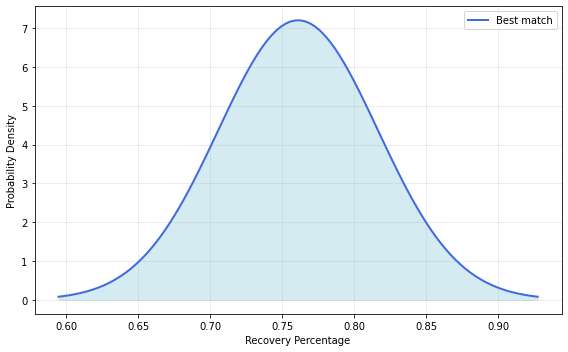

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math


def plot_gaussian_recovery_percentage(mu, sigma, label="", title="", show=False):
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    
    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, color="royalblue", linewidth=2, label=label)
    plt.fill_between(x, y, color="lightblue", alpha=0.5)  # Fill under curve
    
    # Annotate mean and ±1 std deviation
    #plt.axvline(mu, color="red", linestyle="--", label=f"Mean: {mu:.2f}")
    
    # Plot settings
    plt.xlabel("Recovery Percentage")
    plt.ylabel("Probability Density")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if show:
        plt.show()


plot_gaussian_recovery_percentage(
    np.mean(best_strand_match_strand_recoveries),
    np.std(best_strand_match_strand_recoveries), label='Best match', show=True)


### Consensus

In [18]:
def get_recovery_percentage(reference, decoded_strand):
    return sum([
        i==j for i, j in zip(reference, decoded_strand)
        ])/len(reference)

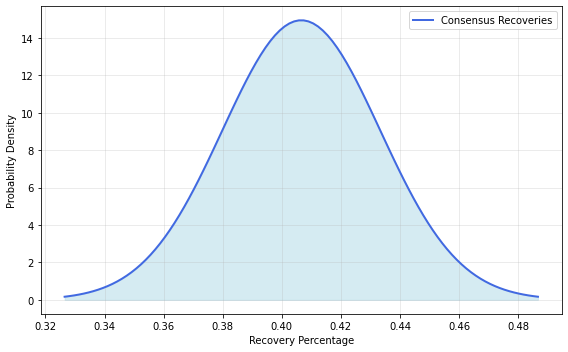

In [22]:

consensus_recoveries = []

for strand_model in strand_models:

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    consensus_recovery = sequencing_model.consensus_decoding(
        sequenced_strands=sequenced_strands,
        original_strand=original_strand
    )

    consensus_recoveries.append(consensus_recovery)

plot_gaussian_recovery_percentage(
    np.mean(consensus_recoveries),
    np.std(consensus_recoveries), label='Consensus Recoveries', show=True)

### Longest strand Recovery

In [25]:
def get_longest_strand_match_recovery(reference, sequenced_strands):

    longest_strand = ""
    for strand in sequenced_strands:
        if len(strand) > len(longest_strand):
            longest_strand = strand
            
    return sum([i==j for i, j in zip(longest_strand, reference)])/len(reference)

In [26]:

longest_strand_recoveries = []

for strand_model in strand_models:

    original_strand = strand_model.strand
    sequenced_strands = strand_model.sequenced_strands

    longest_strand_recovery = get_longest_strand_match_recovery(
        reference=original_strand,
        sequenced_strands=sequenced_strands
    )

    longest_strand_recoveries.append(
        longest_strand_recovery
    )


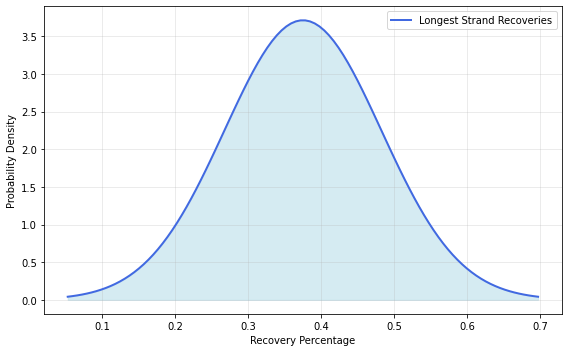

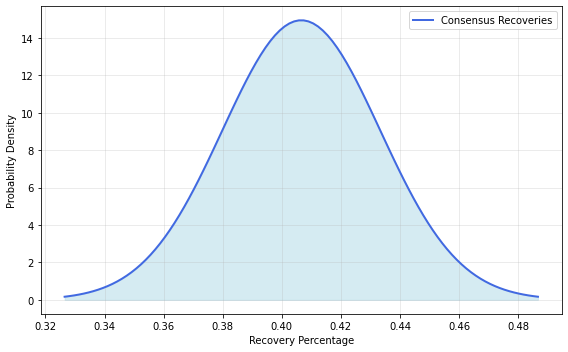

In [32]:
plot_gaussian_recovery_percentage(
    np.mean(longest_strand_recoveries),
    np.std(longest_strand_recoveries), label='Longest Strand Recoveries', show=False)

plot_gaussian_recovery_percentage(
    np.mean(consensus_recoveries),
    np.std(consensus_recoveries), label='Consensus Recoveries', show=False)
